# Étape 1 : Importation des Bibliothèques

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Étape 2 : Chargement des Données

In [10]:
data = pd.read_csv("../quest.csv")

# Aperçu et nettoyage des données

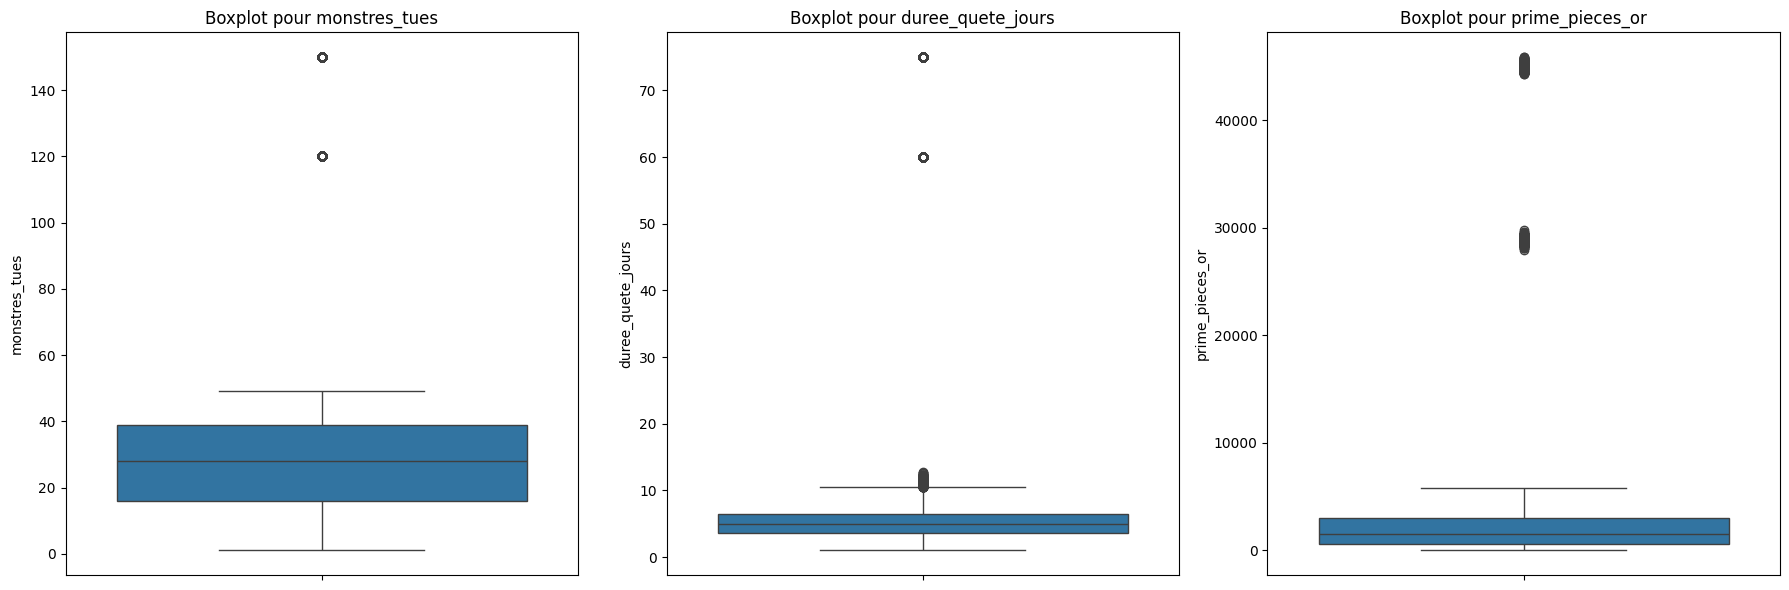

In [11]:
data = data.dropna()
data = data[(data['monstres_tues'] >= 0) & (data['duree_quete_jours'] >= 0) & (data['prime_pieces_or'] >= 0)]
plt.figure(figsize=(18, 6))
for i, col in enumerate(['monstres_tues', 'duree_quete_jours', 'prime_pieces_or'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=data[col])
    plt.title(f"Boxplot pour {col}")
plt.tight_layout()
plt.show()

# Suppression des outliers

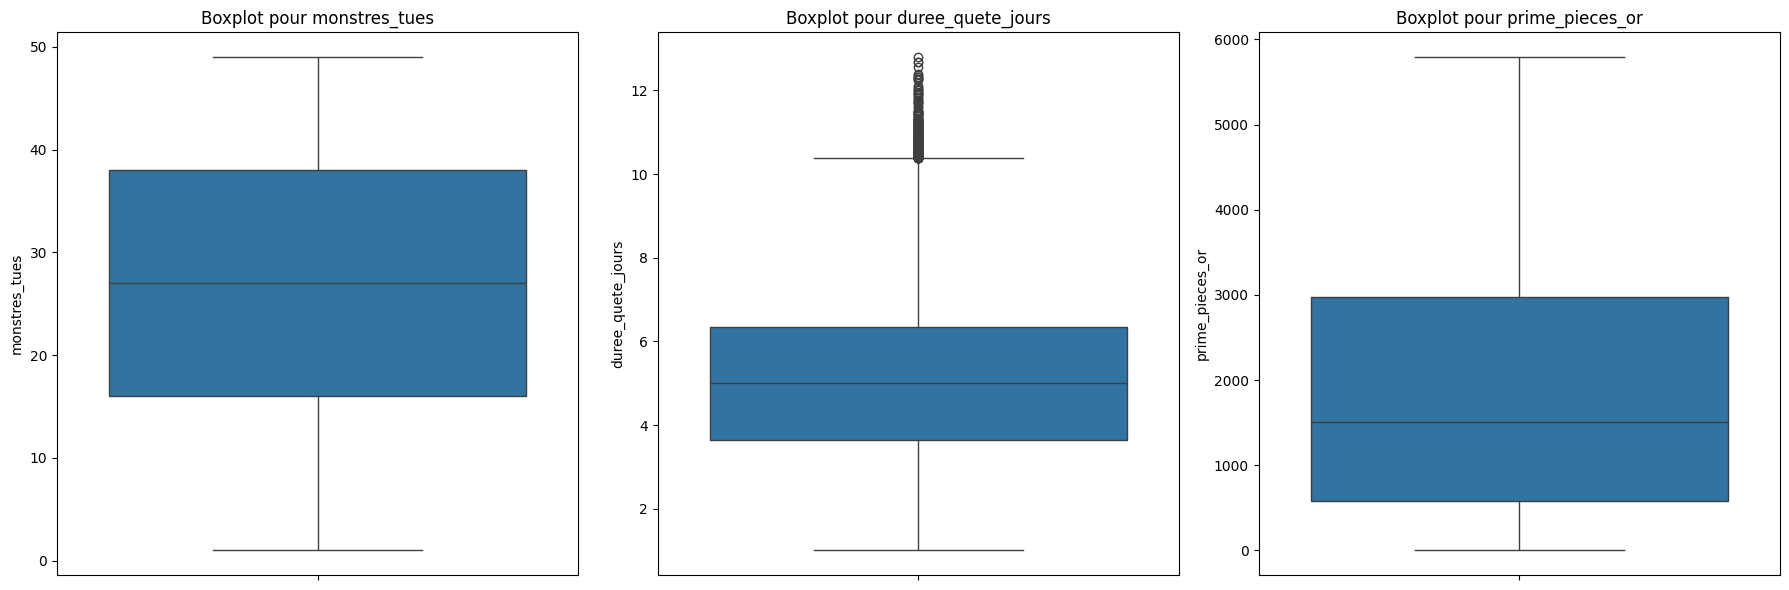

In [12]:
data = data[(data['monstres_tues'] <= 80) & (data['duree_quete_jours'] <= 15) & (data['prime_pieces_or'] <= 10000)]
plt.figure(figsize=(18, 6))
for i, col in enumerate(['monstres_tues', 'duree_quete_jours', 'prime_pieces_or'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=data[col])
    plt.title(f"Boxplot pour {col}")
plt.tight_layout()
plt.show()

# Étape 3 : Préparation des Données

In [13]:
X = data[['monstres_tues', 'duree_quete_jours']]
y = data['prime_pieces_or']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Étape 4 : Modèles à tester

In [14]:
param_grids = {
    "Lasso": {'model__alpha': np.logspace(-10, 10, 50)},
    "Ridge": {'model__alpha': np.logspace(-10, 10, 50)},
    "RandomForest": {
        'model__n_estimators': [100],
    },
    "GradientBoosting": {
        'model__n_estimators': [100],
        'model__learning_rate': [0.01, 0.1, 0.2],
    },
    "XGBRegressor": {
        'model__n_estimators': [100],
        'model__learning_rate': [0.01, 0.1, 0.2],
    }
}
models = {
    "Lasso": GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('model', Lasso())]),
        param_grids["Lasso"], cv=5, scoring='r2'
    ),
    "Ridge": GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('model', Ridge())]),
        param_grids["Ridge"], cv=5, scoring='r2'
    ),
    "LinearRegression": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    "RandomForest": GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(random_state=42))]),
        param_grids["RandomForest"], cv=5, scoring='r2'
    ),
    "GradientBoosting": GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('model', GradientBoostingRegressor(random_state=42))]),
        param_grids["GradientBoosting"], cv=5, scoring='r2'
    ),
    "XGBRegressor": GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('model', XGBRegressor(random_state=42))]),
        param_grids["XGBRegressor"], cv=5, scoring='r2'
    )
}

# Entraînement et évaluation de chaque modèle

In [15]:
model_performances = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    # Extraire le meilleur modèle et ses paramètres pour les modèles avec GridSearchCV
    best_model = model.best_estimator_ if isinstance(model, GridSearchCV) else model
    best_params = model.best_params_ if isinstance(model, GridSearchCV) else None
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    model_performances[model_name] = {
        'model': best_model, 'r2': r2, 'best_params': best_params
    }
    print(f"{model_name} - R²: {r2:.2f}, Meilleurs paramètres: {best_params}")

Lasso - R²: 0.89, Meilleurs paramètres: {'model__alpha': np.float64(0.6250551925273976)}
Ridge - R²: 0.89, Meilleurs paramètres: {'model__alpha': np.float64(1.5998587196060574)}
LinearRegression - R²: 0.89, Meilleurs paramètres: None
RandomForest - R²: 0.94, Meilleurs paramètres: {'model__n_estimators': 100}
GradientBoosting - R²: 0.96, Meilleurs paramètres: {'model__learning_rate': 0.1, 'model__n_estimators': 100}
XGBRegressor - R²: 0.96, Meilleurs paramètres: {'model__learning_rate': 0.1, 'model__n_estimators': 100}


# Choix du meilleur modèle basé sur les performances

In [16]:
best_model_name = max(model_performances, key=lambda x: model_performances[x]['r2'])
best_model = model_performances[best_model_name]['model']
print(f"\nLe modèle sélectionné est : {best_model_name}")


Le modèle sélectionné est : GradientBoosting


# Étape 5 : Visualisation des Performances du Meilleur Modèle

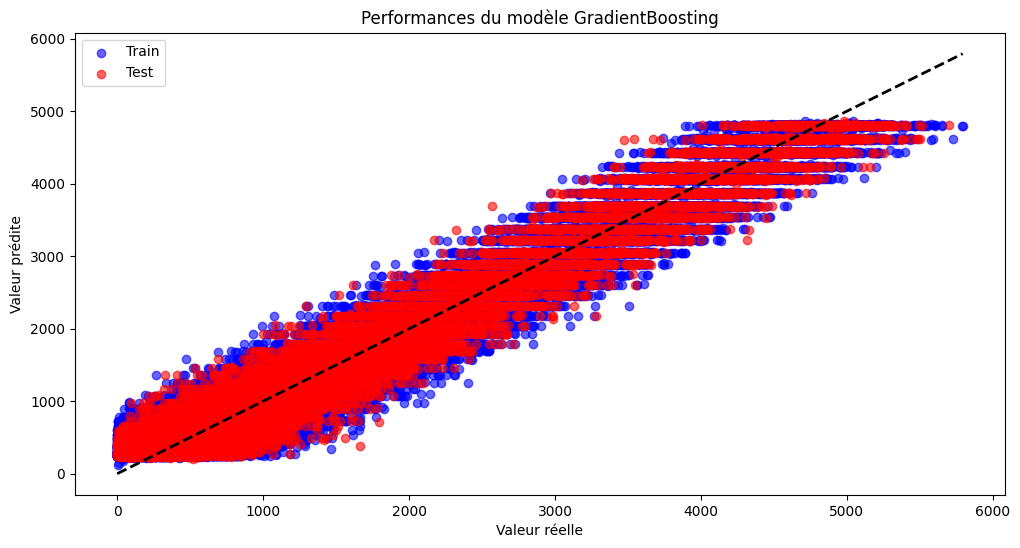

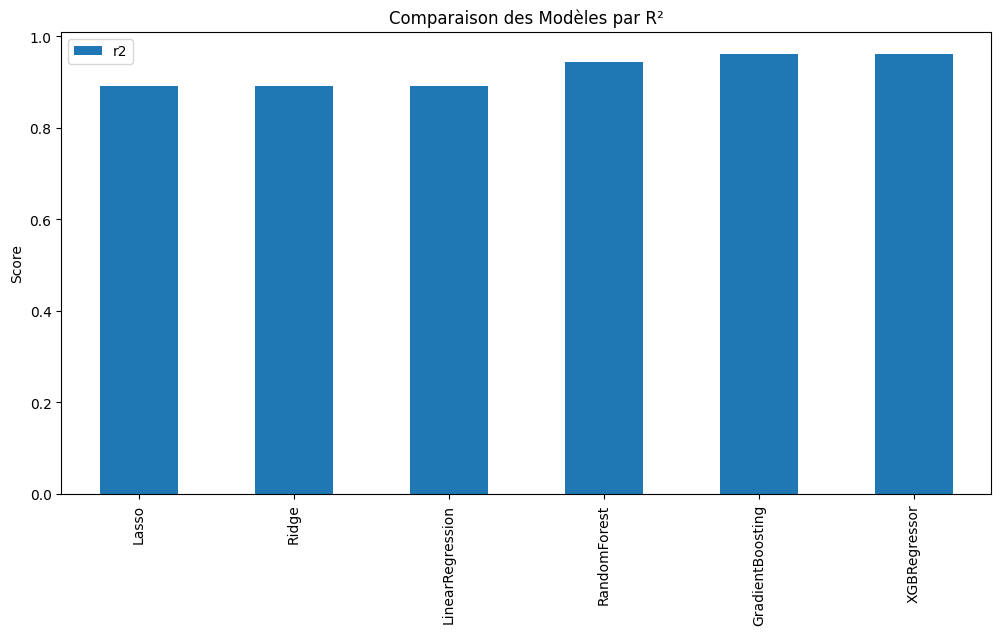

In [17]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_pred_train, color="blue", alpha=0.6, label="Train")
plt.scatter(y_test, y_pred_test, color="red", alpha=0.6, label="Test")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Valeur réelle")
plt.ylabel("Valeur prédite")
plt.title(f"Performances du modèle {best_model_name}")
plt.legend()
plt.show()

performance_df = pd.DataFrame(model_performances).T[['r2']]
performance_df.plot(kind='bar', figsize=(12, 6), title="Comparaison des Modèles par R²")
plt.ylabel("Score")
plt.show()

# Étape 6 : Prédictions finales pour des nouvelles quêtes

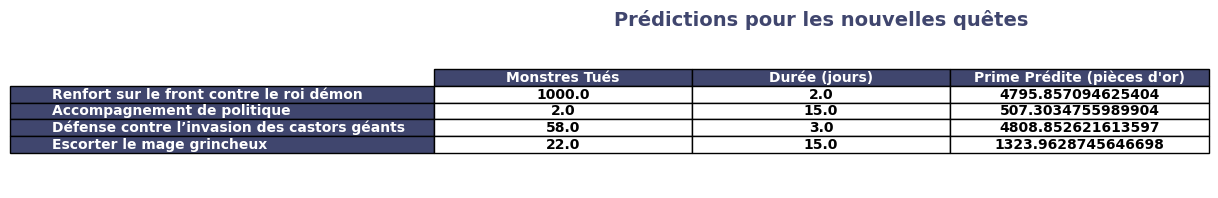

In [18]:
new_quests = pd.DataFrame({
    'monstres_tues': [1000, 2, 58, 22],
    'duree_quete_jours': [2, 15, 3, 15]
}, index=[
    "Renfort sur le front contre le roi démon",
    "Accompagnement de politique",
    "Défense contre l’invasion des castors géants",
    "Escorter le mage grincheux"
])
new_quests['prime_predite'] = model_performances[best_model_name]['model'].predict(new_quests)
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis("tight")
ax.axis("off")
table = ax.table(cellText=new_quests.values, 
                 colLabels=["Monstres Tués", "Durée (jours)", "Prime Prédite (pièces d'or)"], 
                 rowLabels=new_quests.index, 
                 cellLoc="center", 
                 loc="center")
for key, cell in table.get_celld().items():
    cell.set_fontsize(12)
    cell.set_text_props(weight="bold")
    if key[0] == 0 or key[1] == -1:
        cell.set_facecolor("#40466e")
        cell.set_text_props(color="white")
plt.title("Prédictions pour les nouvelles quêtes", fontsize=14, weight='bold', color="#40466e")
plt.show()